Project3-ObjectDetection_GoStop
===
---
목표: Object Detection의 바운딩 박스 데이터셋을 전처리하여 자율주행 시스템을 만들고 이를 평가해보자.

데이터 : `KITTI` 데이터셋

- 7,481개의 학습 데이터(training data)
- 711개의 평가용 데이터(test data)
- 423개의 검증용 데이터(validation data)
- 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보

모델 : `RetinaNet`

## 1. 데이터 전처리

#### 필요한 라이브러리를 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

#### KITTI 데이터셋을 다운로드

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#### 다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보기

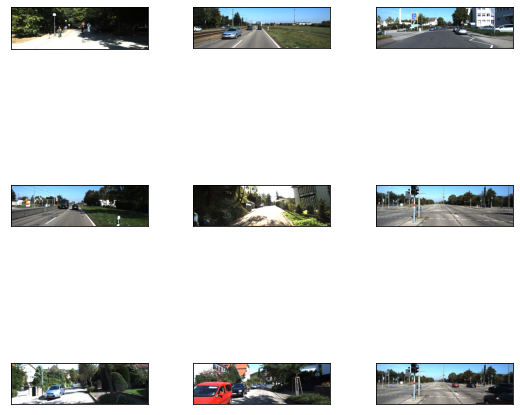

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

#### 데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj63/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

#### ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 TakeDataset을 얻기

In [5]:
TakeDataset = ds_train.take(1)

#### 데이터 정보를 확인해보기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-0.86, -1.6 , -0.51,  1.44,  1.77,  1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.0027027 , 0.        , 0.45554054, 0.24836601],
       [0.41256756, 0.8102206 , 0.60175675, 0.8412255 ],
       [0.45089188, 0.8252696 , 0.58402705, 0.96843135],
       [0.45332432, 0.3608987 , 0.53432435, 0.3954902 ],
       [0.4384054 , 0.29299837, 0.5387027 , 0.31436273],
       [0.39505404, 0.16185458, 0.51954055, 0.24050653]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.72, 0.78, 1.71],
       [1.51, 1.75, 4.45],
       [1.44, 1.64, 3.68],
       [1.87, 0.86, 2.12],
       [1.63, 1.78, 4.54]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ -3.16,   1.68,   3.35],
       [ 10.47,   0.9 ,  18.34],
       [ 16.09

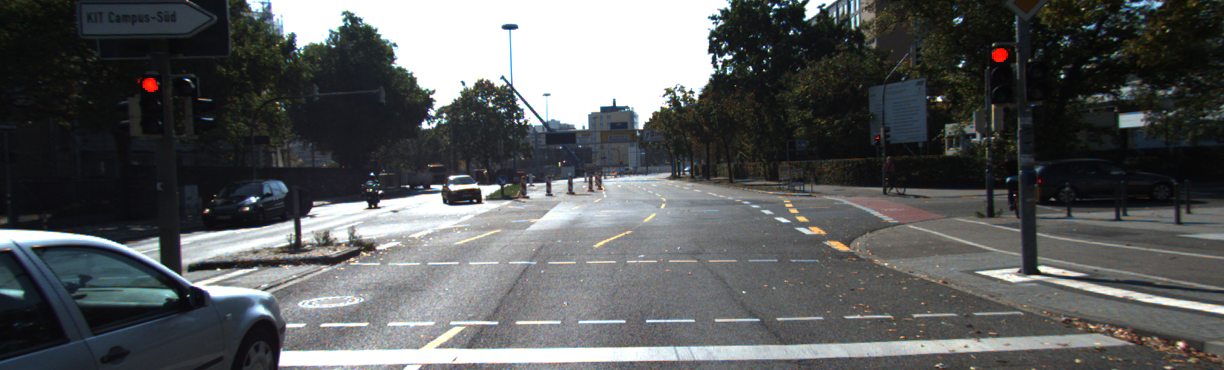

In [6]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

## 2. 바운딩 박스 처리하기

#### 이미지 위에 바운딩 박스를 그려서 시각화

width: 1224  height: 370
(6, 4)
[  0.   369.   304.   201.45]
[ 991.71  217.35 1029.66  147.35]
[1010.12994  203.17    1185.36     153.90999]
[441.74002 202.27    484.08002 172.29999]
[358.63    207.79001 384.78    170.68   ]
[198.11 223.83 294.38 177.77]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7F2D8C59DED0>


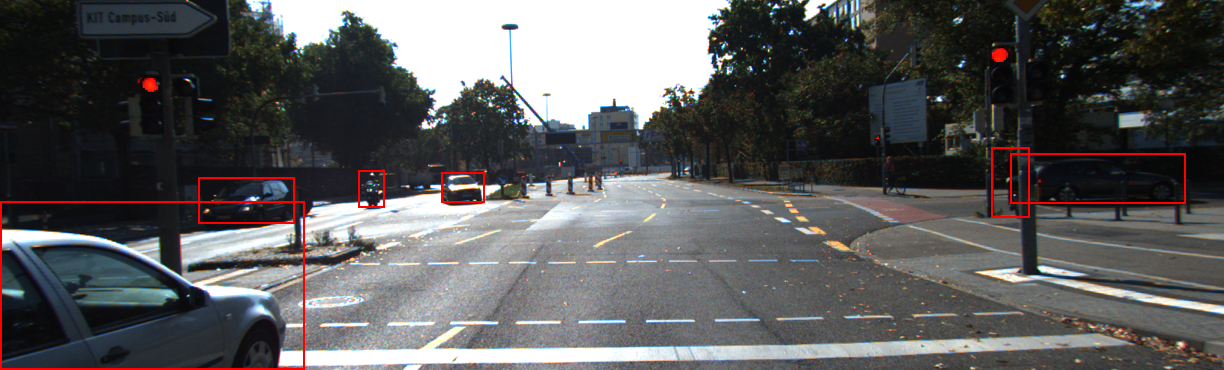

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

#### 바운딩 박스를 적용해주는 함수만들기 및 train data에 대해 적용해주기

In [8]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인
    # 기존의 class를 차와 사람으로 나누기
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:57<00:00,  8.16it/s]


#### test data에 대해 적용해주기

In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:37<00:00,  7.28it/s]


#### label 바꿔주기

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

||변경 전|변경 후|
|:---:|:---:|:---:|
|label|car|0|
||person|1|

#### 사용된 기기 확인

In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14482790713546115684,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6505550336
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14231032424280443808
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

#### GPU 사용여부 확인

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### RetinaNet 훈련

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-18 02:41:33.434248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-18 02:41:35.133254: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-18 02:41:35.133831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-18 02:41:35.166167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-18 02:41:35.167552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-18 02:41:35.167618: I tensorflow/stream_executor/platform/default/d

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "retinanet"
_________________________________________________________________________________

2021-04-18 02:41:38.278005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-18 02:41:38.278623: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2021-04-18 02:41:44.109297: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynam

Epoch 11/50
195/195 [==============================] - 56s 283ms/step - loss: 1.6050 - regression_loss: 1.2646 - classification_loss: 0.3404

Epoch 00011: saving model to ./snapshots/resnet50_csv_11.h5
Epoch 12/50
195/195 [==============================] - 56s 283ms/step - loss: 1.5246 - regression_loss: 1.1854 - classification_loss: 0.3392

Epoch 00012: saving model to ./snapshots/resnet50_csv_12.h5
Epoch 13/50
195/195 [==============================] - 56s 283ms/step - loss: 1.5469 - regression_loss: 1.1981 - classification_loss: 0.3488

Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
Epoch 14/50
195/195 [==============================] - 56s 283ms/step - loss: 1.4278 - regression_loss: 1.0948 - classification_loss: 0.3330

Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
Epoch 15/50
195/195 [==============================] - 56s 283ms/step - loss: 1.5043 - regression_loss: 1.1832 - classification_loss: 0.3211

Epoch 00015: saving model to ./snapshots/resnet50_

195/195 [==============================] - 56s 283ms/step - loss: 1.0377 - regression_loss: 0.7878 - classification_loss: 0.2498

Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 33/50
195/195 [==============================] - 56s 283ms/step - loss: 1.0917 - regression_loss: 0.8223 - classification_loss: 0.2693

Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
Epoch 34/50
195/195 [==============================] - 56s 283ms/step - loss: 1.0545 - regression_loss: 0.7923 - classification_loss: 0.2622

Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
Epoch 35/50
195/195 [==============================] - 56s 284ms/step - loss: 1.0757 - regression_loss: 0.8184 - classification_loss: 0.2573

Epoch 00035: saving model to ./snapshots/resnet50_csv_35.h5
Epoch 36/50
195/195 [==============================] - 56s 284ms/step - loss: 1.0673 - regression_loss: 0.8076 - classific

#### 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환

In [14]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-18 03:29:52.445168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-18 03:29:54.211912: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-18 03:29:54.214150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-18 03:29:54.246502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-18 03:29:54.247913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-18 03:29:54.248001: I tensorflow/stream_executor/platform/default/d

#### load된 모델을 통해 추론을 하고 시각화하는 함수를 작성

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### 이미지에 대해 추론하는 inference_on_image 함수 만들기

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[594.28375 175.65747 627.531   205.64543]
[193.8023  135.68074 349.8348  229.5264 ]


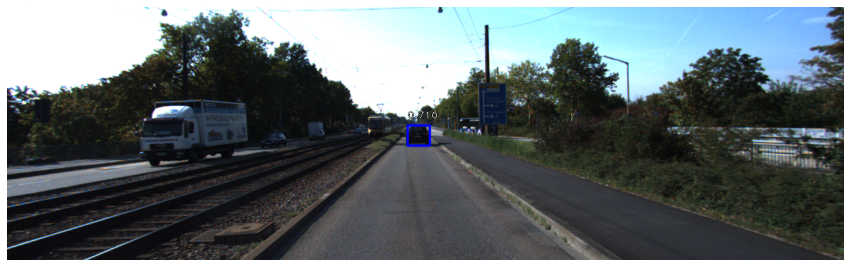

In [16]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'


def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

#### 이미지 한 장 가져와 확인해보기

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[773.75745 147.50261 842.33276 316.90445]
[765.72565 150.32306 847.1017  310.5336 ]


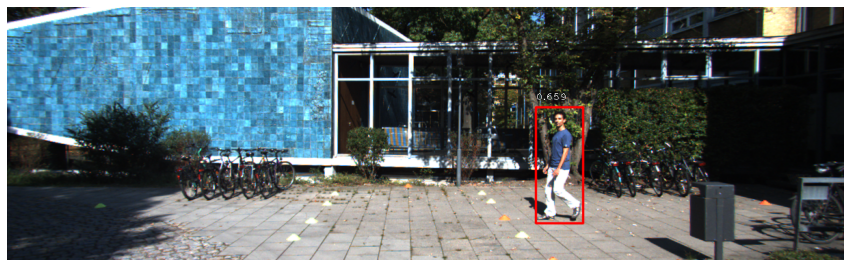

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

## 자율주행 시스템 만들기

- 입력으로 이미지 경로를 받는다.
- 정지조건에 맞는 경우 `Stop`을 아닌 경우 `Go`를 반환한다. <br/>
    정지조건
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기가 (width or height)가 300 px 이상인 경우
- 입력된 이미지도 같이 출력
- 결과조건도 같이 출력

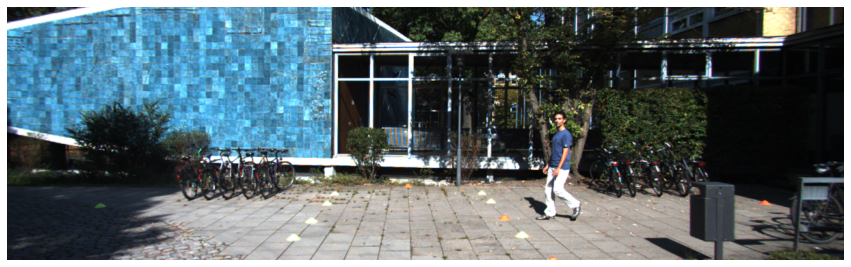

Stop
Stop


In [18]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):

    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()            
    

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        if label == 1 or (label == 0 and ((box[3]-box[1] >= size_limit) or (box[2]-box[0] >= size_limit))):  
            print("Stop")
            return "Stop"
        else:
            print("Go")
            return "Go"
        
print(self_drive_assist(img_path)) 

## 자율주행 시스템 평가하기

`Stop`이미지 5장, `Go`이미지 5장 입력하고 평가하기

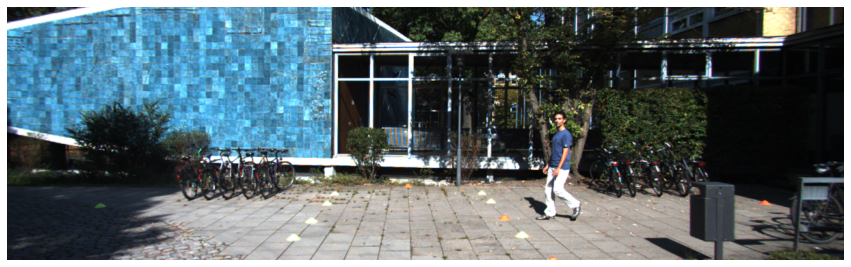

Stop


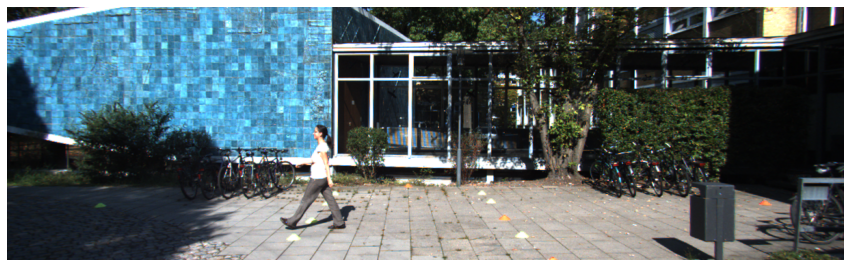

Stop


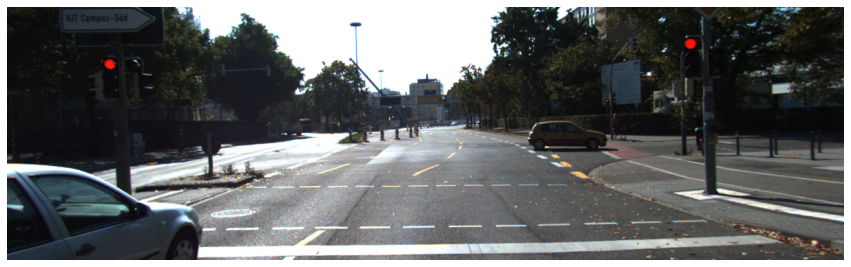

Stop


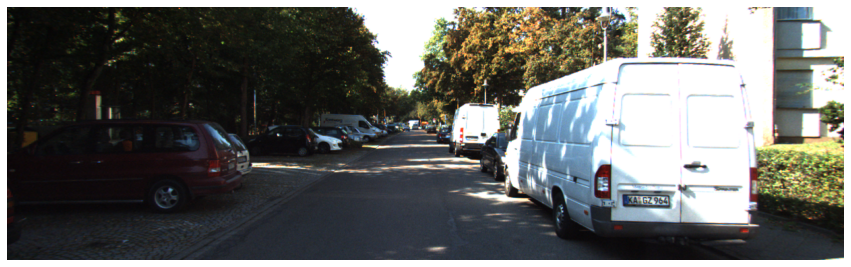

Stop


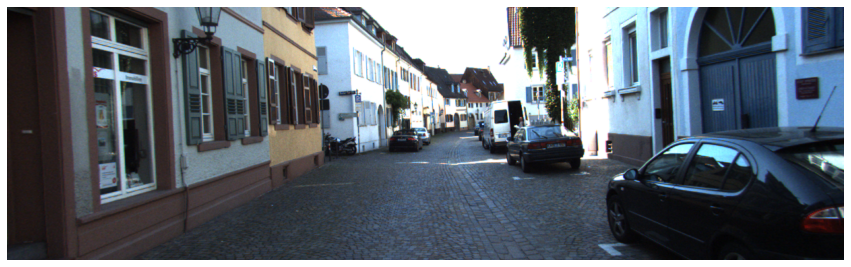

Stop


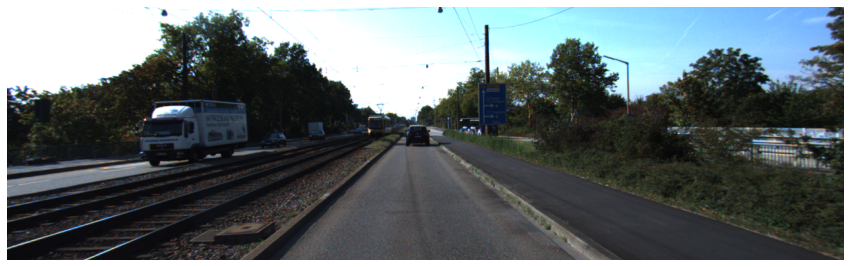

Go


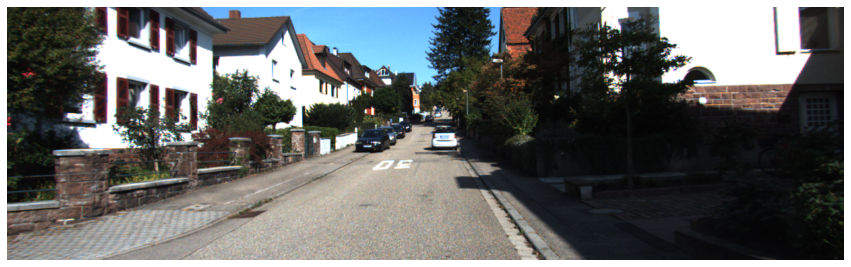

Go


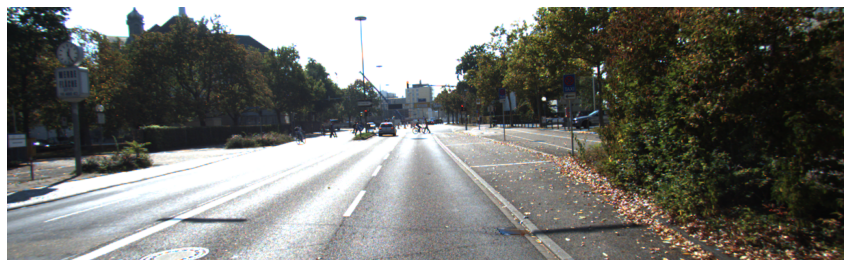

Go


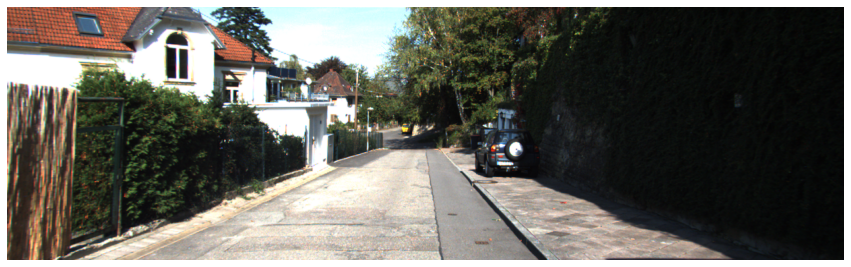

Go


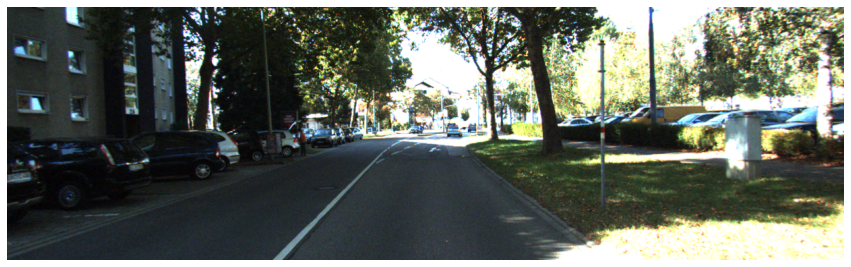

Go
100점입니다.


In [19]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## 회고

- inference_on_image 함수
    - 대부분의 코드 역할과 진행을 알 수 있는 함수였다. 이미지를 입력으로 받고 출력할 수 있는 방법들의 아이디어를 얻을 수 있었다. 이를 자율주행 시스템 만드는 함수에 적용하여 이미지와 결과도 같이 출력할 수 있도록 응용해보았다.
    
- 주어진 조건에 따라 자율주행 시스템을 만드는 함수
    - boxs, scores, labels가 여러 개의 bbox를 가지고 있기 때문에 여러 값을 가지고 있으므로 이 안에 함수들을 불러오기 위해 zip, enumerate 함수를 사용했다. 그 안의 값들에 대해서 위의 조건을 적용하는 함수를 만들어 해결하였다.
    

## 루브릭

KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
- 다운로드부터 EDA, 바운딩박스 만들기, 라벨 바꿔주기에 이르기까지 가공을 진행하였다.

바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
- 평가하는 함수를 돌리면 이미지와 결과가 나오면서 시각화된 이미지를 생성할 수 있도록 하였다.

테스트 수행결과 90% 이상의 정확도를 보였다.
- 100%의 정확도를 가지고 있다.